In [1]:
import glob
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
import numpy as np

In [2]:
def load_image_dataset(path_to_images, resize=None):
    paths = glob.glob(path_to_images)

    dataset = None

    if resize:
        dataset = np.zeros((len(paths), resize[0], resize[1], 3))
    else:
        dataset = np.zeros((len(paths), 512, 512, 3))

    for i, path_to_img in enumerate(paths):
        img = keras.utils.load_img(path_to_img)
        img = keras.preprocessing.image.img_to_array(img)

        if resize:
            img = tf.image.resize(img, resize)

        img = img / 255.
        dataset[i] = img
    return dataset

In [3]:
x_train = load_image_dataset('../data/kpop/*.jpg', (64, 64))

In [ ]:
# plt.figure(figsize=(10, 10))
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(x_train[i])
#     plt.axis("off")

### With Upsampling Layer
- a simple layer with no weights that will double the dimensions of input

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)

input_img = keras.Input(shape=(64, 64, 3))

# Encoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
encoded = layers.Dense(1028, activation='relu')(x)

encoder = keras.Model(input_img, encoded, name='model_encoder')

# Decoder
input_decoder = layers.Dense(2048, activation='relu')(encoded)

x = layers.Reshape((8, 8, 32))(input_decoder)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

decoded = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

### With Transpose Convolutional Layer
- an inverse convolutional layer that will both upsample input and learn how to fill in details during the model training process

In [4]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)

input_img = keras.Input(shape=(64, 64, 3))

# Encoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
encoded = layers.Dense(1028, activation='relu')(x)

encoder = keras.Model(input_img, encoded, name='model_encoder')

# Decoder
input_decoder = layers.Dense(2048, activation='relu')(encoded)

x = layers.Reshape((8, 8, 32))(input_decoder)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)

decoded = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

In [5]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464 

In [6]:
autoencoder.compile(optimizer=optimizer, loss='mse')

tensorboard --logdir=./data/autoencoder

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=15000,
                batch_size=128,
                shuffle=True,
                validation_split=0.10,
                callbacks=[TensorBoard(log_dir='../data/autoencoder')])

Epoch 1/15000
40/40 [==============================] - 7s 40ms/step - loss: 0.1024 - val_loss: 0.0516
Epoch 2/15000
40/40 [==============================] - 1s 27ms/step - loss: 0.0365 - val_loss: 0.0327
Epoch 3/15000
40/40 [==============================] - 1s 32ms/step - loss: 0.0270 - val_loss: 0.0260
Epoch 4/15000
40/40 [==============================] - 1s 30ms/step - loss: 0.0228 - val_loss: 0.0223
Epoch 5/15000
40/40 [==============================] - 1s 27ms/step - loss: 0.0206 - val_loss: 0.0206
Epoch 6/15000
40/40 [==============================] - 1s 27ms/step - loss: 0.0190 - val_loss: 0.0200
Epoch 7/15000
40/40 [==============================] - 1s 27ms/step - loss: 0.0190 - val_loss: 0.0183
Epoch 8/15000
40/40 [==============================] - 1s 27ms/step - loss: 0.0175 - val_loss: 0.0192
Epoch 9/15000
40/40 [==============================] - 1s 27ms/step - loss: 0.0166 - val_loss: 0.0169
Epoch 10/15000
40/40 [==============================] - 1s 27ms/step - loss: 0.015

In [58]:
autoencoder.save(f"../models/ModelCNNAutoEncoder-{15000}.model")

INFO:tensorflow:Assets written to: ../models/ModelCNNAutoEncoder-2000.model\assets


INFO:tensorflow:Assets written to: ../models/ModelCNNAutoEncoder-2000.model\assets


In [2]:
autoencoder = keras.models.load_model('../models/ModelCNNAutoEncoder-2000.model/')

In [6]:
def load_img(path_to_img, resize=None):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, resize)
  return img

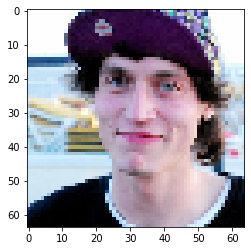

In [7]:
path = '../data/ko.jpg'
x = load_img(path, (64, 64))

plt.imshow(x)

In [8]:
test_decoded_imgs = autoencoder.predict(np.array([x]))

1/1 [==============================] - 10s 10s/step


Koray concat Kpop

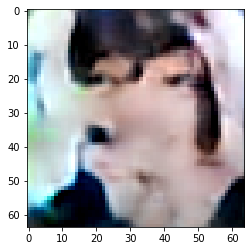

In [22]:
plt.imshow(test_decoded_imgs.reshape(64, 64, 3));

In [10]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [37]:
%matplotlib inline
def plot_image(image, title=""):
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

def preprocess_image(image_path):
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

In [14]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(SAVED_MODEL_PATH)

In [25]:
lr = preprocess_image('../data/pko.png')

In [26]:
fake_image = model(lr)
fake_image = tf.squeeze(fake_image)

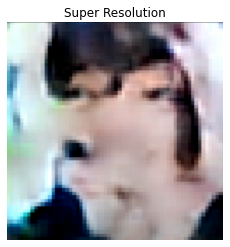

In [27]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")

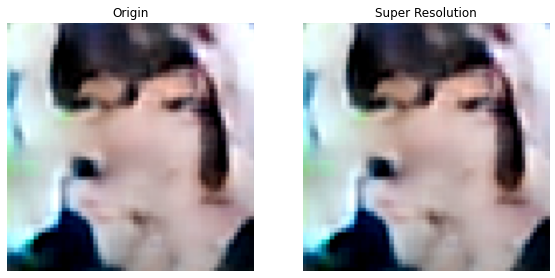

In [42]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 2)
plt.subplot(131)
plot_image(tf.squeeze(lr), "Origin")
plt.subplot(132)
plot_image(tf.squeeze(fake_image), "Super Resolution")
# plt.savefig("pko_supreso.jpg", bbox_inches="tight")